In [0]:
import geopandas as gp
from geopandas import GeoDataFrame
import numpy as np
import matplotlib.pyplot as plt
import math 
import statistics
import heapq as hq
%matplotlib inline
import _locale
_locale._getdefaultlocale = (lambda *args: ['en_US', 'utf8'])
import time
import matplotlib.ticker as plticker

Below is the starting function which is the entry point for the program and this calls all the other required functions.
1. Loading the shape file from the directory.
2. Input Grid Size(format example: 0.003) and Threshold

In [0]:
def showMap():
    
    path = "Shape/crime_dt.shp"
    
    test = GeoDataFrame.from_file(path,encoding='latin-1')
    points = test['geometry']
    xA = np.array(test['geometry'].x)
    yA = np.array(test['geometry'].y)

    gridSize = input("Enter grid size : " )
    threshold = input("Enter Threshold : ")
    threshold = int(threshold)
    gridSize = float(gridSize) 
    startTime = time.time()
    calculateThreshold(points,xA,yA,threshold,gridSize,startTime)

#### Helper Function
heuristicFunction() -  Calculates the pythagorean distance between 2 points

In [0]:
def heuristicFunction(x, y):
    value =  np.sqrt((y[0] - x[0]) ** 2 + (y[1] - x[1]) ** 2)
    return value

#### Helper Function
pathCalculate() - This implements the A* heuristic search to calculate the optimal path
The algorithm starts with the start location and using the heuristic function to calculate the F(n) using the cost of nodes and path i.e., F(n) = G(n) + Cost. 

f(n) = g(n) + h(n), where 

f(n) estimate of total cost along path through n

g(n) actual cost of path from start to node n

h(n) estimate of cost to reach goal from node n

In [0]:
def pathCalculate(array,start,end,value,status,directions,fn,shortestPath,positions,pathDict,gn,hq):
    
    while shortestPath:

        current = hq.heappop(shortestPath)[1]
        if current == end:
            while current in pathDict:
                value.append(current)
                current = pathDict[current]
            return value

        positions.add(current)
        for i, j in directions:
            adjacent = current[0] + i, current[1] + j
            temp_g = gn[current] + heuristicFunction(current, adjacent)
            if 0 <= adjacent[0] < array.shape[0]:
                if 0 <= adjacent[1] < array.shape[1]:                
                    if array[adjacent[0]][adjacent[1]] == 1:
                        continue
                else:
                    # out of bound for Y axis
                    continue  
            else:
                 # out of bound for X axis
                continue 
                 
            if adjacent in positions and temp_g >= gn.get(adjacent, 0):
                continue
                
            if  temp_g < gn.get(adjacent, 0) or adjacent not in [i[1]for i in shortestPath]:
                pathDict[adjacent] = current
                gn[adjacent] = temp_g
                fn[adjacent] = temp_g + heuristicFunction(adjacent, end)
                hq.heappush(shortestPath, (fn[adjacent], adjacent))
                
    return value   

#### calculateThreshold()
The below function divides the loaded data into normalized bins based on the grids and the threshold in the input and using the matplotlib plots the 2-D histogram for the map. 

In [0]:
def calculateThreshold(points,xA,yA,threshold,gridSize,startTime):
    
    xMin, xMax, yMin, yMax = -73.59,-73.55,45.49,45.53
    noOfRows = math.ceil((xMax - xMin)/gridSize)
    noOfColumns = math.ceil((yMax - yMin)/gridSize)  
    
    crimeDict = {}
    
    for i in range(len(points)):
        k = xA[i],yA[i]
        if k in crimeDict.keys():
            crimeDict[xA[i],yA[i]]  = crimeDict[xA[i],yA[i]] + 1  
        else:
            crimeDict[xA[i],yA[i]] = 1
    
    listX = np.array([])
    listY = np.array([])
    
    xAA = []
    yAA = []
    
    for i,j in dict(sorted(crimeDict.items(), key=lambda kv: kv[1], reverse=True)).keys():
        xAA = np.append(xAA,i)
        yAA = np.append(yAA,j)
          
    for i in range(int((noOfRows*noOfColumns)*((100-threshold)/100))):
            listX = np.append(listX,xAA[i])
            listY = np.append(listY,yAA[i])
#             x = sum(listX)/len(listX)
#             y = sum(listY)/len(listY)
    
#             print("MEAN : ", x,y)
    l = plt.hist2d(listX,listY,bins=(noOfRows+1,noOfColumns+1))
    
    lat = []
    long = []
    
    x = sum(listX)/len(listX)
    y = sum(listY)/len(listY)
    
    print("MEAN ALL : ", x,y)
    
    print("Standard Deviation : " , statistics.stdev(listX),statistics.stdev(listY))
   
    xR=noOfRows+1
    yR = noOfColumns+1
    length = (len(l[0]))
    parse = np.array([[0]*xR]*yR)
    
    
    for i in range(0,length-1):
        for j in range(0,length-1):
            if l[0][i][j] > 0:
                parse[i][j] = 1 
            else:
                parse[i][j] = 0
    
    parse = parse.transpose()
    parse = parse[::-1]
   
    start =(noOfRows,noOfColumns)
    goal = (0,0)
    
    value = []
    status = False
    directions = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    lly=['45.495','45.500','45.505','45.510','45.515','45.520','45.525','45.530']
    fn = {start:heuristicFunction(start, goal)}
    shortestPath = []
    positions = set()
    pathDict = {}
    gn = {start:0}
    hq.heappush(shortestPath, (fn[start], start))
    
    
    solutionPath = pathCalculate(parse,start,goal,value,status,directions,fn,shortestPath,positions,pathDict,gn,hq)
    
    if parse[start] == 1 or parse[goal] == 1 or solutionPath == []:
           print("ROUTE CANNOT BE TRAVERSED !")
    else:
            
        solutionPath = solutionPath + [start]
        solutionPath = solutionPath[::-1]
        lll =['-73.585','-73.580','-73.575','-73.570','-73.565','-73.560','-73.555','-73.550']
        l = plt.hist2d(xA,yA,bins=(noOfRows+1,noOfColumns+1))
       
        x_coords = []
        y_coords = []

        for i in (range(0,len(solutionPath))):
            x = solutionPath[i][0]
            y = solutionPath[i][1]
            x_coords.append(x)
            y_coords.append(y)
            
        fig, ax = plt.subplots()
        ax.imshow(parse)
    
        ax.scatter(goal[1],goal[0], marker = 's')
        ax.scatter(start[1],start[0], marker = 's')
        ax.plot(y_coords,x_coords, color = "white")
        
        labels = [item.get_text() for item in ax.get_xticklabels()]
        labelsy = [item.get_text() for item in ax.get_yticklabels()]
        
        baseSize = (noOfRows / 7)
        loc = plticker.MultipleLocator(base = baseSize) 

        loc1 = plticker.MultipleLocator(base = baseSize)
        ax.xaxis.set_major_locator(loc)
        ax.yaxis.set_major_locator(loc1)
        
        
        for i in range(0,len(lll)):
            if i+1 >= len(labels):
                labels.append(lll[i])
            else:
                labels[i+1] = lll[i]
        ax.set_xticklabels(labels)

        
        j = 7
        for i in range(0,len(lly)):
            if i+1 >= len(labelsy) or j<0:
                labelsy.append(lly[j])
            else:
                labelsy[i+1] = lly[j]
            j = j - 1
        ax.set_yticklabels(labelsy)
         
        end = time.time()
       
        plt.show()
        
        print("Time - taken :", end - startTime)      

Enter grid size : 0.002
Enter Threshold : 75
MEAN ALL :  -73.57045416159714 45.50779059892379
Standard Deviation :  0.008607186998834155 0.009115655463443785


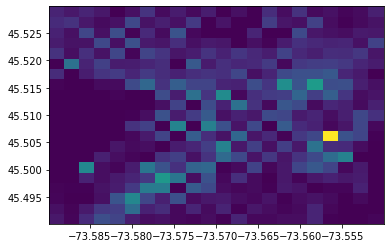

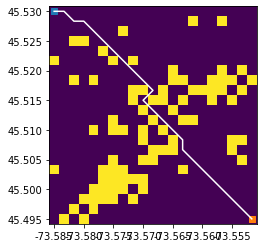

Time - taken : 0.20193195343017578


In [0]:
showMap()